In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap
import copy

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [ ]:
df = pd.read_csv("emails.csv")
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


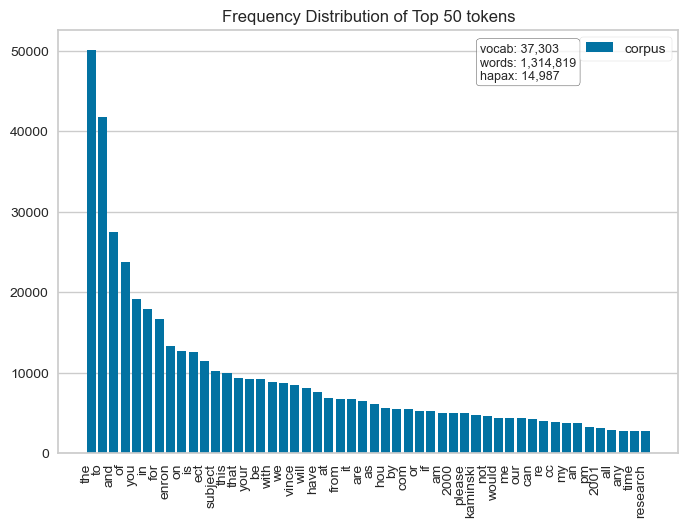

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [3]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [4]:
text = df["text"]
labels = df["spam"]

print(text.shape, labels.shape)

(5728,) (5728,)


In [5]:
# remove digits, @-mentions, links, stopwords

text = text.str.lower()
text = text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
text = text.apply(lambda x : nltk.word_tokenize(x))
text = text.apply(lambda x : " ".join([word for word in x if word not in nltk.corpus.stopwords.words()]))

text.shape

(5728,)

In [6]:
import pickle
with open("text.pkl", "wb") as f:
  pickle.dump(text, f)
with open("labels.pkl", "wb") as f:
  pickle.dump(labels, f)

In [3]:
import pickle
with open("text.pkl", "rb") as f:
  text = pickle.load(f)
with open("labels.pkl", "rb") as f:
  labels = pickle.load(f)

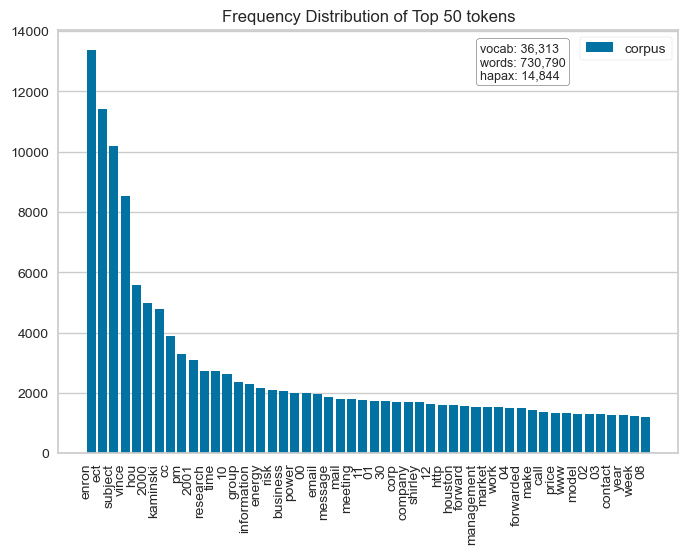

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [30]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(text)
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
lengths = []

X = text
for i in range(len(text)):
  X[i] = tokenizer.tokenize(X[i])
  X[i] = tokenizer.convert_tokens_to_ids(X[i])

for i in range(len(X)):
  lengths.append(len(X[i]))

In [6]:
lengths = np.array(lengths)
X = np.array(X)

print(lengths)
print(len(lengths))
print(np.sum(lengths < 512) / len(lengths))
print(np.sum(lengths < 512))
print(np.max(lengths))

[270 102  58 ... 426 261 327]
5728
0.8837290502793296
5062
6176


In [7]:
lengths = np.array(lengths)
X = np.array(X)

print(np.sum((lengths < 64) & (labels == 1)), np.mean((lengths < 64) & (labels == 1)))
print(np.sum((lengths < 64) & (labels == 0)), np.mean((lengths < 64) & (labels == 0)))

371 0.0647695530726257
786 0.13722067039106145


In [8]:
X_positive = X[(lengths < 64) & (labels == 1)].tolist()
X_negative = X[(lengths < 64) & (labels == 0)].tolist()
X = X_positive[:300] + X_negative[:300]

y_positive = labels[(lengths < 64) & (labels == 1)].tolist()
y_negative = labels[(lengths < 64) & (labels == 0)].tolist()
y = y_positive[:300] + y_negative[:300]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=500, shuffle=True)

X_test = X_test[:50]
y_test = y_test[:50]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
import torch

model.config.max_position_embeddings = 64
max_length = model.config.max_position_embeddings

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [11]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2238, -0.2139, -0.0937,  ..., -0.6627,  0.3024, -0.2404],
         [-0.4468,  0.3267,  0.2392,  ..., -0.5385,  0.3945,  0.4824],
         [-0.2357,  0.7478,  0.5156,  ..., -0.6696,  0.2838,  0.2933],
         ...,
         [-0.1273, -0.3057,  0.0937,  ..., -0.8019,  0.3241, -0.3298],
         [-0.1353, -0.2929,  0.0959,  ..., -0.7974,  0.3367, -0.3291],
         [-0.1245, -0.2674,  0.0868,  ..., -0.7859,  0.3113, -0.3387]],

        [[ 0.2632, -0.0445,  0.5285,  ..., -0.3884,  0.0178, -0.1654],
         [-0.0846, -0.1192,  0.2193,  ..., -0.2041, -0.3045,  0.3460],
         [ 0.0887, -0.1191,  0.2191,  ..., -0.3558, -0.4639,  0.1666],
         ...,
         [ 0.4638, -0.0612,  1.2037,  ..., -0.9476,  0.0173, -0.1807],
         [ 0.4574, -0.0343,  1.2108,  ..., -0.9339,  0.0213, -0.2007],
         [ 0.4792, -0.0197,  1.1979,  ..., -0.9118, -0.0503, -0.2492]],

        [[-0.3897, -0.0582,  0.0777,  ..., -0.8510,  

In [12]:
bert_train_output = bert_train_output[1].detach().numpy().copy()
bert_train_output = bert_train_output.reshape(X_train.shape[0], 768)

In [13]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-2.5317e-01, -3.9866e-02,  2.8526e-01,  ..., -8.5647e-01,
           5.2549e-01,  6.9114e-03],
         [-9.5561e-02, -2.3505e-01,  6.7381e-01,  ..., -5.7916e-01,
           4.1826e-01,  6.5259e-02],
         [ 3.1958e-02, -4.3076e-01,  9.0258e-01,  ..., -6.5260e-01,
           4.5290e-01,  2.4721e-01],
         ...,
         [-2.1419e-01,  8.6616e-03,  3.6978e-01,  ..., -9.8719e-01,
           4.5582e-01, -9.0694e-02],
         [-2.1227e-01,  2.7831e-02,  3.8166e-01,  ..., -9.8774e-01,
           4.4241e-01, -1.0551e-01],
         [-2.0639e-01,  3.8168e-02,  3.8537e-01,  ..., -9.7438e-01,
           3.9593e-01, -1.2064e-01]],

        [[-2.0330e-01, -1.5989e-01, -6.6987e-02,  ..., -7.1528e-01,
           7.4484e-01,  1.7295e-02],
         [-2.9518e-01,  4.3164e-01,  5.2560e-01,  ..., -3.6906e-01,
          -3.6768e-02,  3.0022e-01],
         [-3.0033e-01,  5.4958e-01,  5.4673e-01,  ..., -3.6139e-01,
          -2.

In [14]:
bert_test_output = bert_test_output[1].detach().numpy().copy()
bert_test_output = bert_test_output.reshape(X_test.shape[0], 768)

In [15]:
clf = neural_network.MLPClassifier()
clf.fit(bert_train_output, y_train)

MLPClassifier()

In [16]:
print("Train accuracy:", np.mean(clf.predict(bert_train_output) == y_train))
print("Test accuracy:", np.mean(clf.predict(bert_test_output) == y_test))

Train accuracy: 0.936
Test accuracy: 0.88


In [17]:
print(np.unique(y_test))

[0 1]


In [18]:
np.mean(y_test==0)

0.54

In [2]:
shap.initjs()

In [47]:
to_explain = np.array(X_test_padded)[:10]
to_explain.shape

(10, 64)

In [16]:
def prediction_model(X):
  bert_output = model(torch.from_numpy(np.array(X)).to(torch.int64))
  sequence_output = bert_output[1].detach().numpy()
  return clf.predict(sequence_output.reshape(X.shape[0], 768))

In [5]:
permutation_explainer = shap.explainers.Permutation(prediction_model, to_explain)
#permutation_explainer = shap.explainers.Permutation(clf2.predict, X_test_padded)

In [6]:
permutation_values = permutation_explainer(to_explain)

<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 1042. ... 3465. 1012.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...   

Permutation explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 1042. ... 3465. 1012.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[ 3395.  1024.  3081. ...     0.     0.     0.]
 [ 3395.  1024.  1024. ...     0.     0.     0.]
 [ 3395.  1024.  4007. ...     0.     0.     0.]
 ...
 [ 3395.  1024.  1024. ...     0.     0.     0.]
 [ 3395.  1024. 16169. ...     0.     0.     0.]
 [ 3395.  1024.  1042. ...  3465.  1012.     0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 1042. ... 3465. 1012.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    

Permutation explainer:  30%|███       | 3/10 [47:35<1:25:04, 729.24s/it]

<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 1042. ... 3465. 1012.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...   

Permutation explainer:  40%|████      | 4/10 [1:15:15<1:51:43, 1117.25s/it]

<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...   

Permutation explainer:  50%|█████     | 5/10 [1:53:02<2:08:51, 1546.36s/it]

<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...   

Permutation explainer:  60%|██████    | 6/10 [2:33:57<2:04:08, 1862.17s/it]

<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...   

Permutation explainer:  70%|███████   | 7/10 [3:14:31<1:42:35, 2051.87s/it]

<class 'numpy.ndarray'> [[ 3395.  1024.  3081. ...     0.     0.     0.]
 [ 3395.  1024.  1024. ...     0.     0.     0.]
 [ 3395.  1024.  4007. ...     0.     0.     0.]
 ...
 [ 3395.  1024.  1024. ...     0.     0.     0.]
 [ 3395.  1024. 16169. ...     0.     0.     0.]
 [ 3395.  1024.  1042. ...  3465.  1012.     0.]]
<class 'numpy.ndarray'> [[ 3395.  1024.  3081. ...     0.     0.     0.]
 [ 3395.  1024.  1024. ...     0.     0.     0.]
 [ 3395.  1024.  4007. ...     0.     0.     0.]
 ...
 [ 3395.  1024.  1042. ...  3465.  1012.     0.]
 [ 3395.  1024. 16169. ...     0.     0.     0.]
 [ 3395.  1024.  1042. ...  3465.  1012.     0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[ 3395.  1024.  3081. ...     0.     0.

Permutation explainer:  80%|████████  | 8/10 [3:49:02<1:08:35, 2057.94s/it]

<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 1042. ... 3465. 1012.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[ 3395.  1024.  3081. ...     0.     0.     0.]
 [ 3395.  1024.  1024. ...     0.     0.     0.]
 [ 3395.  1024.  4007. ...     0.     0.     0.]
 ...
 [ 3395.  1024.  3661. ...     0.     0.     0.]
 [ 3395.  1024. 16169. ...     0.     0.     0.]
 [ 3395.  1024.  1042. ...  3465.  1012.     0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    

Permutation explainer:  90%|█████████ | 9/10 [4:09:05<29:49, 1789.05s/it]  

<class 'numpy.ndarray'> [[ 3395.  1024.  3081. ...     0.     0.     0.]
 [ 3395.  1024.  1024. ...     0.     0.     0.]
 [ 3395.  1024.  4007. ...     0.     0.     0.]
 ...
 [ 3395.  1024. 16169. ...     0.     0.     0.]
 [ 3395.  1024.  1042. ...  3465.     0.     0.]
 [ 3395.  1024.  1042. ...  3465.  1012.     0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 1042. ... 3465. 1012.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 1042. ... 3465. 1012.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 3661. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    

Permutation explainer: 100%|██████████| 10/10 [4:30:09<00:00, 1626.13s/it]

<class 'numpy.ndarray'> [[ 3395.  1024.  3081. ...     0.     0.     0.]
 [ 3395.  1024.  1024. ...     0.     0.     0.]
 [ 3395.  1024.  4007. ...     0.     0.     0.]
 ...
 [ 3395.  1024.  1024. ...     0.     0.     0.]
 [ 3395.  1024. 16169. ...     0.     0.     0.]
 [ 3395.  1024.  1042. ...  3465.  1012.     0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[3395. 1024. 3081. ...    0.    0.    0.]
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 4007. ...    0.    0.    0.]
 ...
 [3395. 1024. 1024. ...    0.    0.    0.]
 [3395. 1024. 6396. ...    0.    0.    0.]
 [3395. 1024. 2424. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[ 3395.  1024.  3081. ...     0.     0.     0.]
 [ 3395.  1024.  1024. ... 

Permutation explainer: 11it [4:56:59, 1781.98s/it]                        


In [7]:
print(permutation_values)

.values =
array([[ 0.00000000e+00,  0.00000000e+00,  7.50000000e-02,
         1.00000000e-01, -2.50000000e-02,  3.75000000e-02,
         3.75000000e-02, -2.50000000e-02,  1.25000000e-02,
         6.25000000e-02,  1.12500000e-01,  3.75000000e-02,
        -1.25000000e-02, -1.25000000e-02, -2.50000000e-02,
         5.00000000e-02, -3.75000000e-02, -5.00000000e-02,
        -1.38777878e-17, -7.50000000e-02,  6.25000000e-02,
         8.75000000e-02,  0.00000000e+00,  2.50000000e-02,
        -2.50000000e-02,  6.25000000e-02, -5.00000000e-02,
        -2.50000000e-02,  6.25000000e-02,  7.50000000e-02,
         3.75000000e-02,  1.00000000e-01, -6.25000000e-02,
        -1.25000000e-02,  5.00000000e-02,  3.75000000e-02,
        -1.25000000e-02, -3.75000000e-02, -2.50000000e-02,
         2.50000000e-02,  1.25000000e-02,  3.75000000e-02,
        -2.50000000e-02,  2.50000000e-02,  3.75000000e-02,
        -2.50000000e-02,  2.50000000e-02,  2.50000000e-02,
         2.50000000e-02,  0.00000000e+00,  0.0

<class 'numpy.ndarray'> [[ 3395  1024  3081 17643  1011 10003  3357  2707  1012  3563 14667  1029
    999 20737  6020 20889  2015  1024  1005  1012  3045  1005  1010  1012
  13633  4331  2965  1012  4142  1005  2293  1012     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: subject : via ##gra - proven step start . specific medication ? ! applause superior multitude ##s : ' . winning ' , . continuation politics means . alive ' love . ; Prediction: [1] ; True value: 1


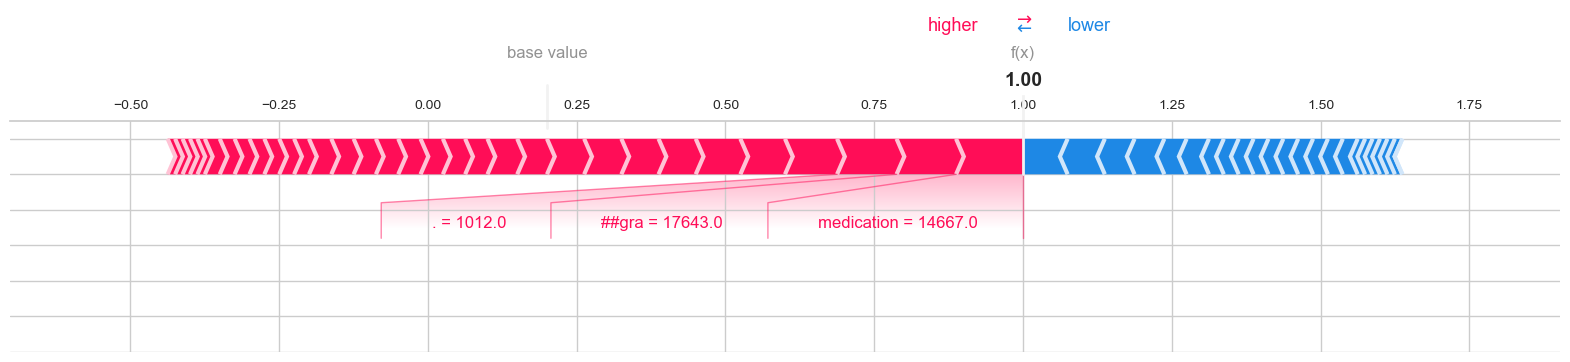

<class 'numpy.ndarray'> [[ 3395  1024  1024  1031  6584  2683  1033  3203  8569  2290 12452  7023
  12391  3081 17643  7000  7751 11562  2185     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: subject : : [ 87 ##9 ] lady ##bu ##g regain confidence generic via ##gra licensed manufacturer click away ; Prediction: [0] ; True value: 1


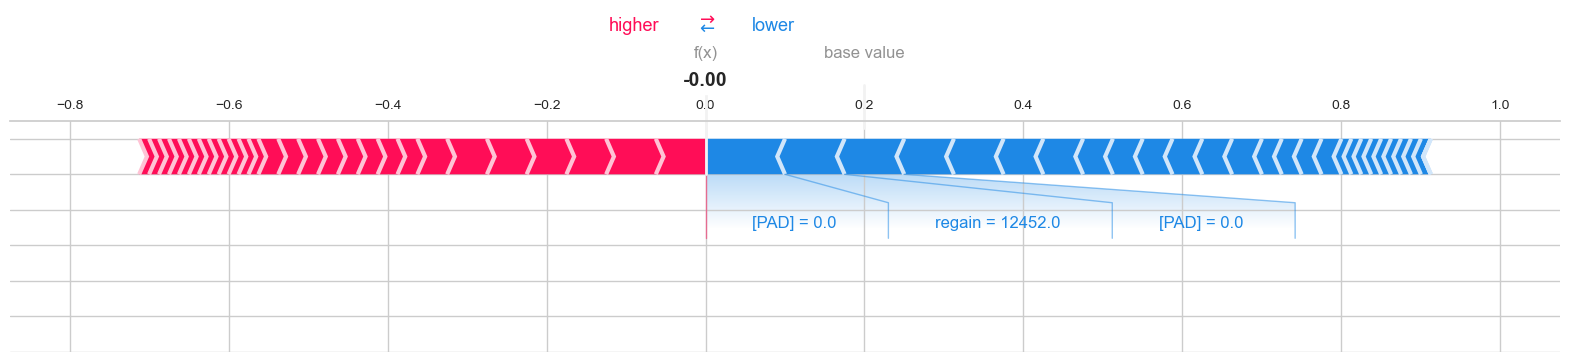

<class 'numpy.ndarray'> [[ 3395  1024  4007 14340  1002  2321  1002  5585  4007  1015  3729  1012
   1015  3120  4007  3565 23809  2063  1012 21435 19240  1010 19240  4623
   1012  4558  8738  4167  3742  1012     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: subject : software cds $ 15 $ 99 software 1 cd . 1 source software super ##stor ##e . slang metaphor , metaphor poetry . lose diet brain mass . ; Prediction: [1] ; True value: 1


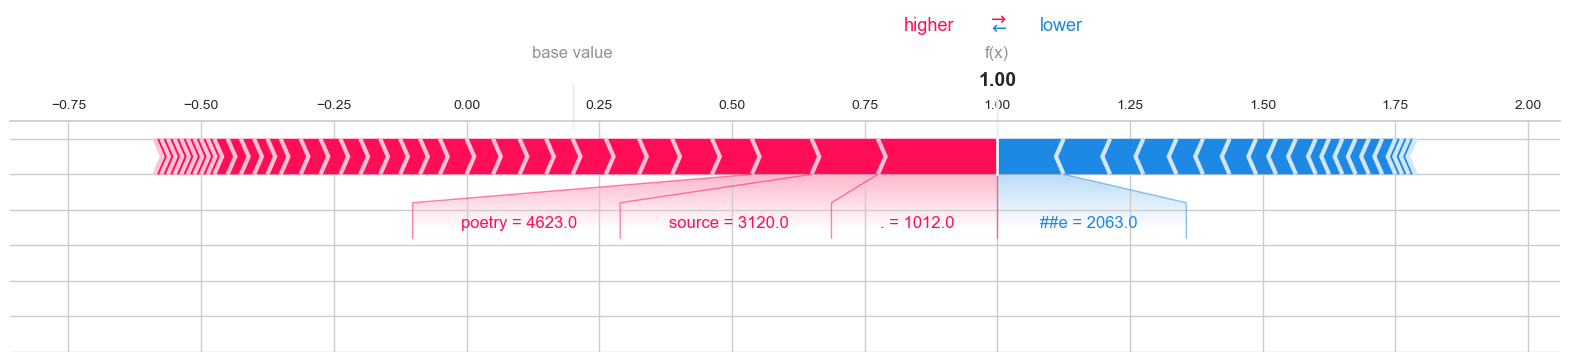

<class 'numpy.ndarray'> [[ 3395  1024  1024  4923  3116  9317  1010  2258  2340  2340  1024  2382
   1010  2733  3180  3116  7422  3952  1016  5739  1024  1015  1012 21934
  10924  2373  7597  1025  1016  1012 11847 16902  2015 21955  2744  3252
   2830  7597  1012  2470  2556 15690  2241  2951  4106  1012  6851 11376
  10837  1012  1010 11280 13675  6132 14238  4041  5463  1012  1012     0
      0     0     0     0]]
Sentence: subject : : credit meeting wednesday , april 11 11 : 30 , week regular meeting devoted primarily 2 subjects : 1 . sim ##ulating power prices ; 2 . capturing correlation ##s commodities term structure forward prices . research present suggestions based data analysis . detailed agenda enclosed . , shirley cr ##ens ##haw planning attend . . ; Prediction: [0] ; True value: 0


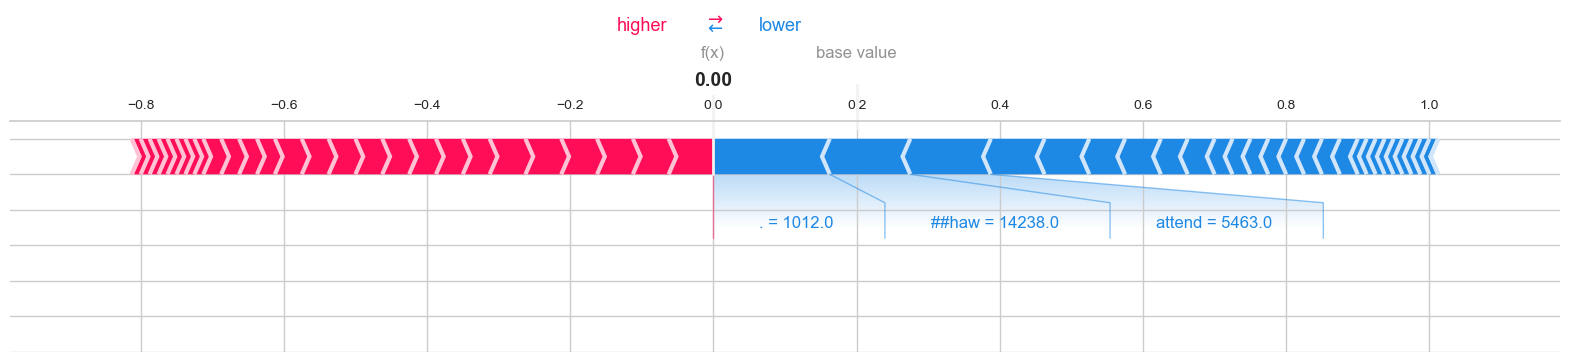

<class 'numpy.ndarray'> [[ 3395  1024 16169  6134  3764  3188  6209  2551  2862  2490  3415  3934
   2470  2551  3902  1012  1029  4532  2829  1010  3208  1010  3116 13058
   4487 13102 20807 25640 21991  3021  1006  1002  1015  1012  1023  1007
   1012  6685  3021  2067  1025  1010  3530  2871  1003  3815  7848  2098
   3021  2541  1010  3155  1002 24643  1012  3980  1010  2655  1012  1012
      0     0     0     0]]
Sentence: subject : allocation schedule spoke prior holiday working list support names projects research working bus . ? sarah brown , manager , meeting corp di ##sp ##uting billing proposing bill ( $ 1 . 9 ) . argument bill back ; , agreed 40 % amount intent ##ed bill 2001 , approximately $ 760 . questions , call . . ; Prediction: [0] ; True value: 0


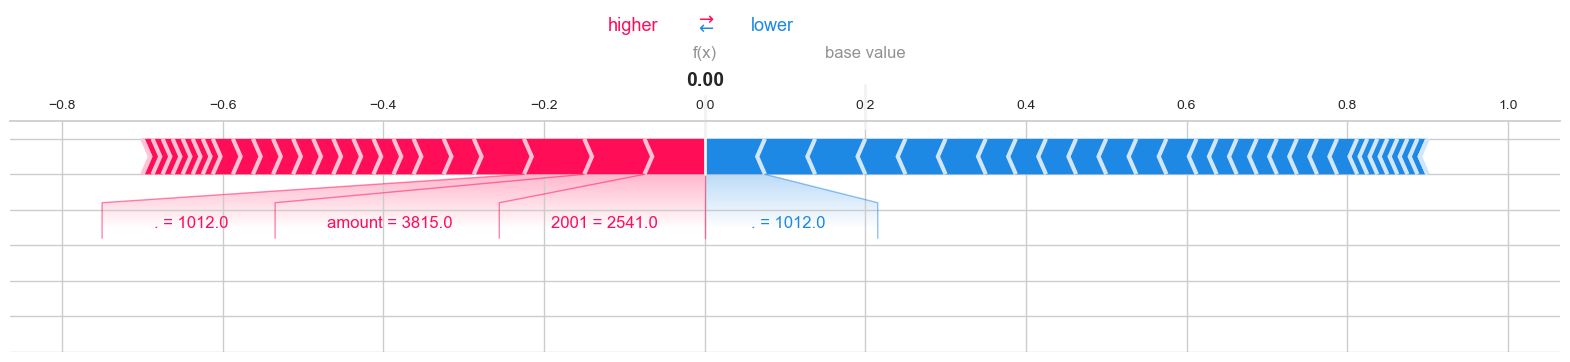

<class 'numpy.ndarray'> [[ 3395  1024  1042  2860  1024  6887  2080  1012  2000 22231  2361  1010
   3645  1010  1012 10882  3401  1012 10036  1012  1051  6633  4007  2164
   7513  1013  7513  2436  1010 18106  1010 26632 16969  1010  4563  2140
   1010  4486 22228  3770  1003  1012  2903  1010  8816  3442  2609  1010
   2568  1005  6402 11163  3729  1010  1005  3729  6402  2121  5653 26581
   4469  3465  1012     0]]
Sentence: subject : f ##w : ph ##o . to ##sho ##p , windows , . fi ##ce . cheap . o ##em software including microsoft / microsoft office , adobe , macro ##media , core ##l , titles macintosh 80 % . believe , download straight site , mind ' burn iso cd , ' cd burn ##er mail doorstep extra cost . ; Prediction: [0] ; True value: 1


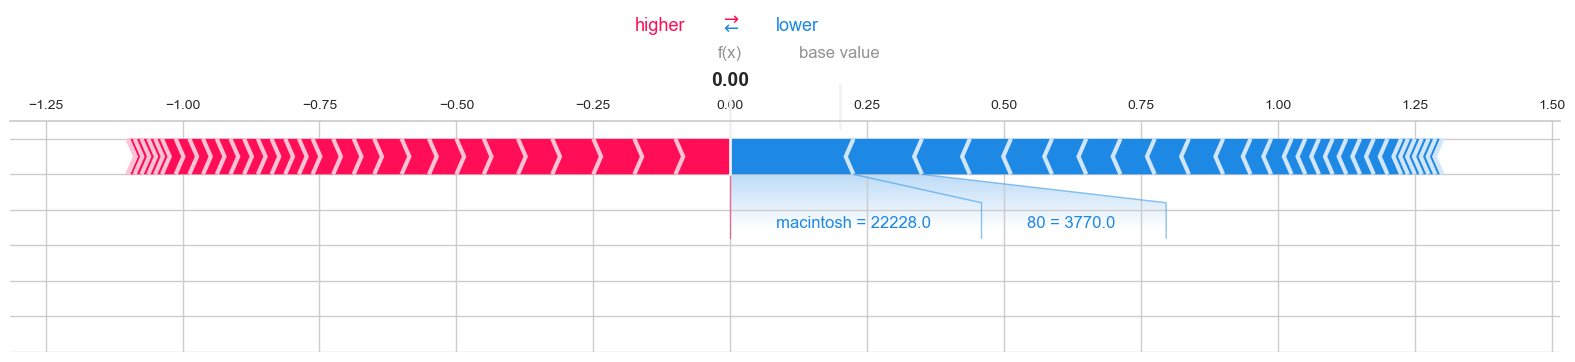

<class 'numpy.ndarray'> [[ 3395  1024  1024  4372  4948  1013  8422  2565  4172  1010  3764  2703
  10958 19053  4140  1010  2132  6202  1041  5910  1010  2167  2637  2851
   1012  3407  4604  1002  2531  1010  2199  2565  5166  1012  2830  2098
   4433  3661 12673  5029  3582  2191  2769 13364  1012  1011  1011  2358
   7076  2239     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: subject : : en ##ron / stanford program nick , spoke paul ra ##cic ##ot , head trading e ##bs , north america morning . happy send $ 100 , 000 program budget . forward ##ed draft letter accompany funds follow make money promptly . - - st ##ins ##on ; Prediction: [0] ; True value: 0


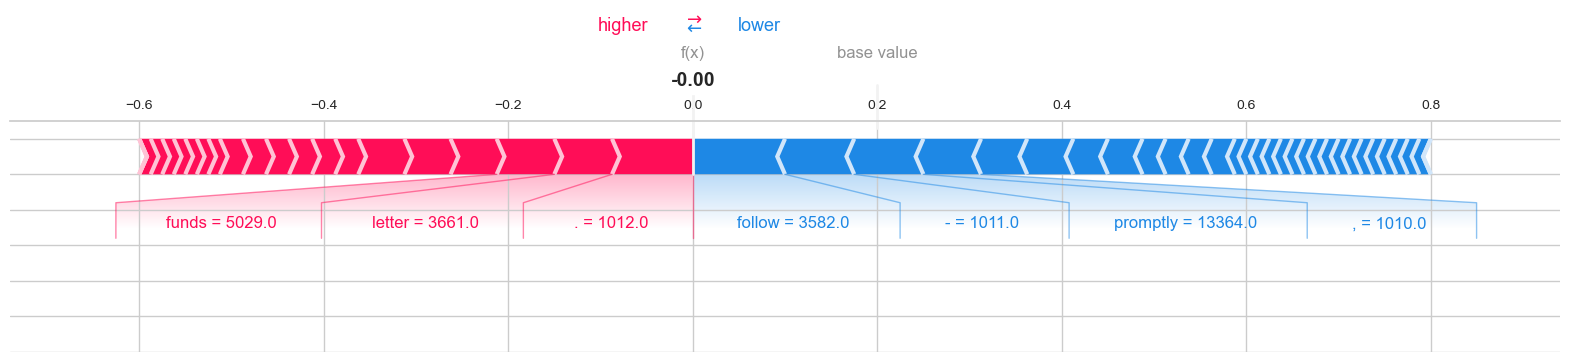

<class 'numpy.ndarray'> [[ 3395  1024  6396  4168  2595  3782  1010  4106  7303  1012  5375  1012
   4918  2057 19932     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: subject : ny ##me ##x chris , analysis requested . assistance . charlie we ##ldon ; Prediction: [0] ; True value: 0


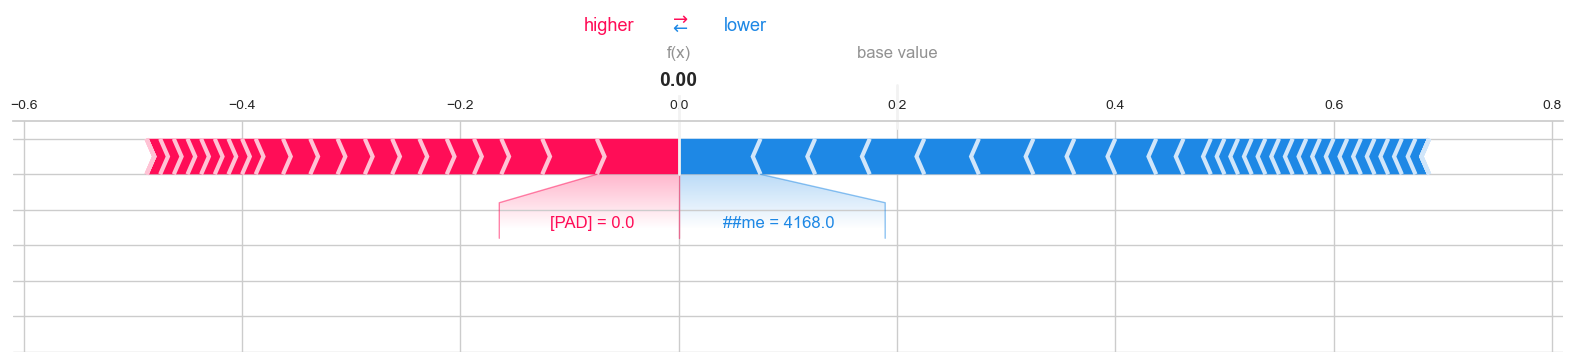

<class 'numpy.ndarray'> [[ 3395  1024  2424  1029  3718  2862  1010 11562  1012     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: subject : find ? removed list , click . ; Prediction: [0] ; True value: 1


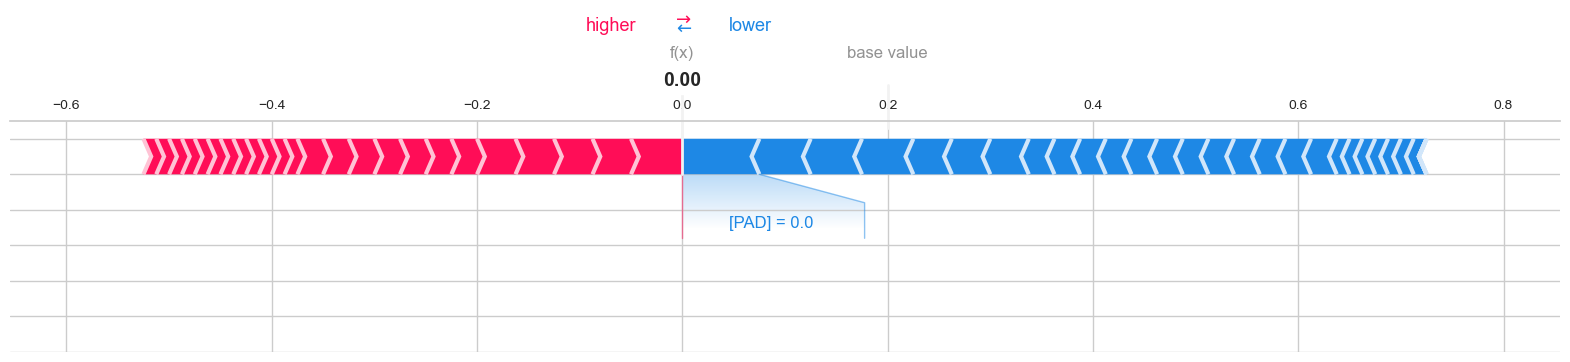

<class 'numpy.ndarray'> [[ 3395  1024  3661 13073  1010  1029  3661  3283  6855  4372  4948  1005
   6226  3793  1012  1029  1029  3967  1029  1029  1010  4604  1029 10319
   3430  6226  1012  1029  1010  7628 13962  1029 18749  9581  2177  1011
   5266  3661  2338 22953 20760  6072  1011  2345  1012  9986     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: subject : letter fiona , ? letter ago obtain en ##ron ' approval text . ? ? contact ? ? , send ? promotional material approval . ? , julie brennan ? lac ##ima group - covering letter book bro ##chu ##res - final . doc ; Prediction: [0] ; True value: 0


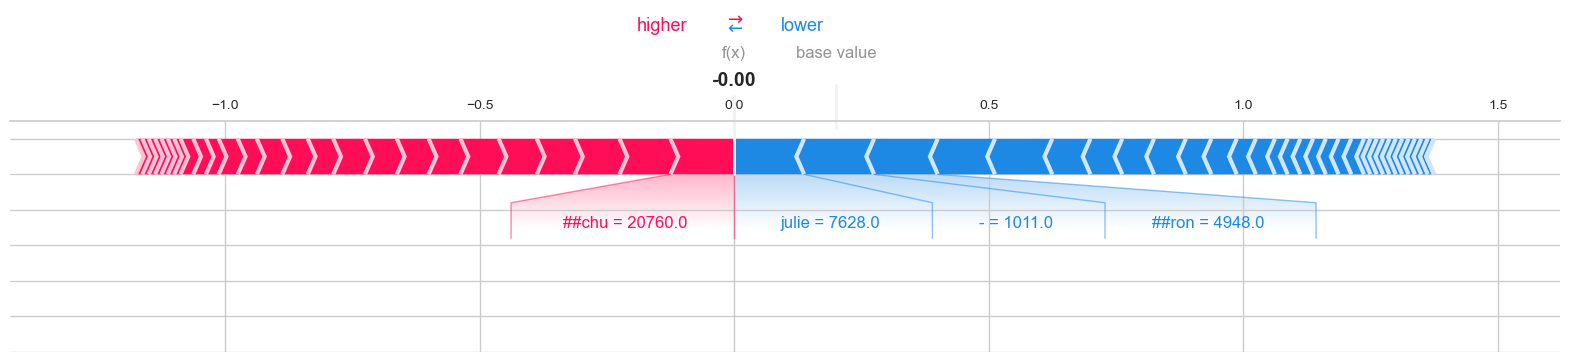

In [11]:
for i in range(len(to_explain)):
  print("Sentence:", " ".join(tokenizer.convert_ids_to_tokens(to_explain[i])).replace(" [PAD]", "") ,"; Prediction:", prediction_model(np.array([to_explain[i]])), "; True value:", y_test[i])
  shap.plots.force(permutation_values.base_values[i], permutation_values.values[i], permutation_values.data[i], feature_names=tokenizer.convert_ids_to_tokens(permutation_values.data[i]), matplotlib=True)

In [131]:
import dill
filename = 'globalsave1.pkl'
sys = None
# to save the session:
dill.dump_session(filename)

# and to load the session again:
# dill.load_session(filename)

PicklingError: Can't pickle <class 'sys.version_info'>: it's not the same object as sys.version_info

In [59]:
def ablate(x, i):
  x[i] = 0
  for j in range(i, len(x)-1):
    x[j] = x[j+1]
  x[-1] = 0
  return x
def compute_contrast(X, model, explanation):
  contrast = [0]*len(X)
  for i in range(len(X)):
    old_prediction = model(np.array([X[i]]))
    for j in range(len(X[i])):
      x = ablate(copy.deepcopy(X[i]), j)
      if (model(np.array(x)) != old_prediction):
        contrast[i] += explanation[i][j]

In [82]:
def compute_distinctiveness(data, train_data, explanation):
  distinctiveness = [0] * len(data)

  frequencies = []
  for x in np.unique(train_data):
    frequencies.append((np.mean(train_data == x), x))
  sorted_frequencies = sorted(frequencies)
  word_specialty = {0: 0}
  for i, (f, x) in enumerate(sorted_frequencies):
    word_specialty[x] = 1 - i / len(sorted_frequencies)

  for i in range(len(data)):
    for j in range(len(data[i])):
      distinctiveness[i] += word_specialty[data[i][j]] * explanation[i][j]

  return distinctiveness

In [61]:
def compute_fidelity(X, explanation, model):
    fidelity = [0] * len(X)
    samples = 10
    for i in range(len(X)):
        change_ratings = [0]*len(X[i])
        for x in range(len(X[i])):
            change_rating = 0
            for change in range(samples):
                new_X = copy.deepcopy(X[i])
                new_X[x] = new_X[x] + (2000 * change / samples)
                if (model(np.array([X[i]])) == model(np.array([new_X]))):
                    change_rating += 1/samples
            change_ratings[x] = change_rating
        for j in range(len(X[i])):
            fidelity[i] += change_ratings[j] * explanation[i][j]

In [128]:
from nltk.corpus import wordnet as wn
def compute_realism(data, id_to_token, topic, explanation):
  """
  data: the word ids in the shape of #elements x #words
  topic: a wordnet synset
  id_to_token: a function from ids to tokens

  returns an array of length #elements
  """
  metrics = [0] * len(data)
  for i in range(len(data)):
    for j in range(len(data[i])):
      print(topic.wup_similarity(wn.synsets(id_to_token([data[i][j]])[0])[0]))
      try:
        metrics[i] += explanation[i][j] * topic.wup_similarity(wn.synsets(id_to_token([data[i][j]])[0])[0])
      except:
        pass
  return metrics

In [65]:
contrast = compute_contrast(to_explain, prediction_model, permutation_values.values)

ValueError: not enough values to unpack (expected 2, got 1)

In [83]:
distinctiveness = compute_distinctiveness(to_explain, np.concatenate((X_train_padded.numpy(), X_test_padded.numpy())), permutation_values.values)

In [68]:
fidelity = compute_fidelity(to_explain, permutation_values.values, prediction_model)

In [129]:
realism = compute_realism(to_explain, tokenizer.convert_ids_to_tokens, wn.synset("spam.n.01"), permutation_values.values)

0.14285714285714285


IndexError: list index out of range

In [119]:
print("contrast:", contrast)
print("distinctiveness:", distinctiveness)
print("fidelity:", fidelity)
print("realism:", realism)

contrast: <function contrast at 0x0000018C70E090D0>
distinctiveness: [0.0889005016722408, 0.010857620640229342, 0.16645664118490194, 0.17451624462494034, 0.051233277591973256, -0.09363652651696126, 0.011631032011466787, -0.02929706163401815, 0.0013766125179168493, 0.16156832298136642]
fidelity: None
realism: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
